In [ ]:
# SETUP AND LIBRARY IMPORTS

!pip install -q torchxrayvision
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchxrayvision as xrv
from torchxrayvision.datasets import imread, apply_transforms
from tqdm.notebook import tqdm

# Configuration class for paths and targets
class CFG:
    DATA_DIR = "/kaggle/input/padchest-buat-ta/"
    SUBFOLDERS = ["folder_1", "folder_2", "folder_3"]
    CSV_PATH = "/kaggle/input/padchest-buat-ta/PADCHEST.csv"
    TARGET_LABELS = ["Infiltration", "Effusion"]

# Custom dataset class for consistent data filtering
class PadChestMultiFolderDataset(xrv.datasets.PC_Dataset):
    def __init__(self, imgpath, subfolders, **kwargs):
        self.subfolders = subfolders
        super().__init__(imgpath=imgpath, **kwargs)

    def __getitem__(self, idx):
        sample = {"lab": self.labels[idx]}
        return sample

print("Configuration and Dataset class are ready.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 56.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00:00:0100:01
Configuration 

Label Distribution Analysis
{'Aortic Elongation', 'Pleural_Thickening', 'Nodule', 'Flattened Diaphragm', 'Pneumothorax', 'Cardiomegaly', 'Pneumonia', 'Tuberculosis', 'Air Trapping', 'Atelectasis', 'Fracture', 'Edema', 'Consolidation', 'Emphysema', 'Hilar Enlargement', 'Costophrenic Angle Blunting', 'Scoliosis', 'Support Devices', 'Hemidiaphragm Elevation', 'Bronchiectasis', 'Mass', 'Aortic Atheromatosis', 'Tube', 'Hernia', 'Granuloma', 'Fibrosis'} will be dropped

Total Valid Samples (PA & AP views only): 94815
--------------------------------------------------
Class: Infiltration | Positive Cases: 8727 (9.20%)
Class: Effusion | Positive Cases: 3937 (4.15%)
--------------------------------------------------


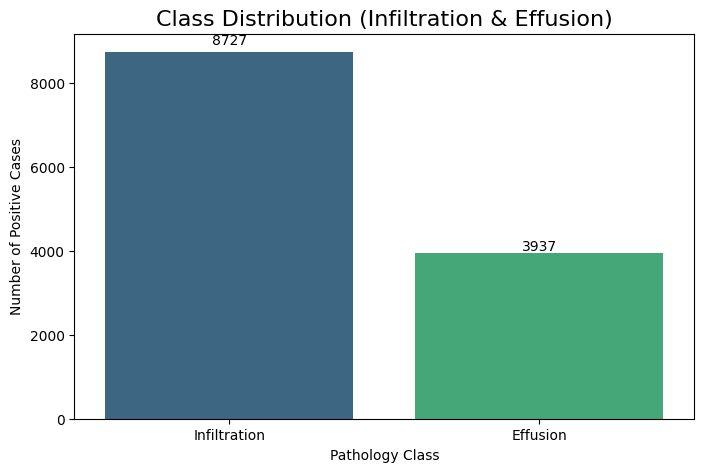


Number of samples where both pathologies appear together: 1342 (1.42%)


Patient Metadata Analysis
Total samples for metadata analysis after cleaning: 94812


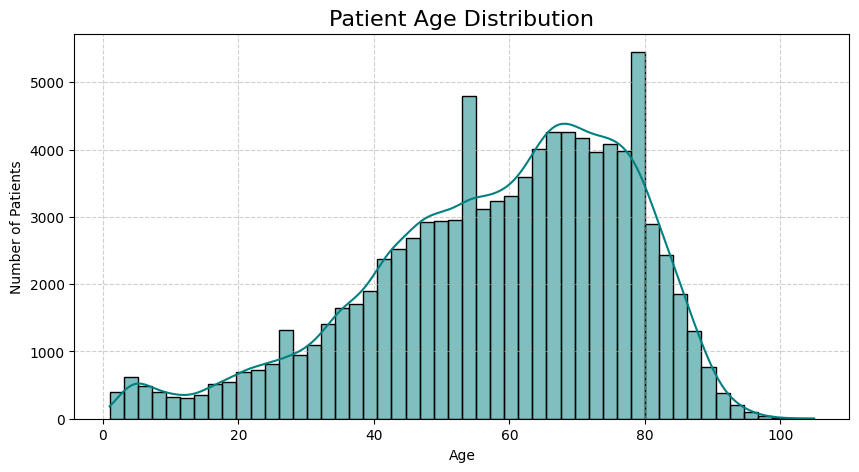

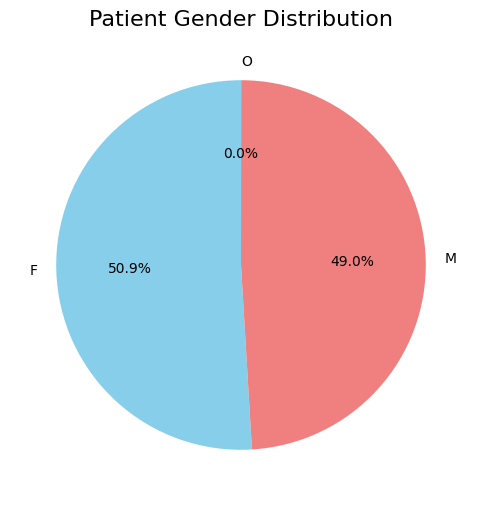

In [2]:
# --- 1. LABEL DISTRIBUTION ANALYSIS (ON FILTERED DATA) ---
print("Label Distribution Analysis")
dataset_for_analysis = PadChestMultiFolderDataset(
    imgpath=CFG.DATA_DIR, 
    subfolders=CFG.SUBFOLDERS, 
    csvpath=CFG.CSV_PATH,
    views=["PA", "AP"],
    transform=None,
    unique_patients=False
)
xrv.datasets.relabel_dataset(CFG.TARGET_LABELS, dataset_for_analysis)

labels_matrix = dataset_for_analysis.labels
labels_matrix = labels_matrix[~np.isnan(labels_matrix).any(axis=1)]
total_samples_filtered = len(labels_matrix)
counts = np.sum(labels_matrix, axis=0)

print(f"\nTotal Valid Samples (PA & AP views only): {total_samples_filtered}")
print("-" * 50)
results = {}
for i, label_name in enumerate(CFG.TARGET_LABELS):
    count = int(counts[i])
    percentage = (count / total_samples_filtered) * 100
    results[label_name] = {'count': count, 'percentage': percentage}
    print(f"Class: {label_name} | Positive Cases: {count} ({percentage:.2f}%)")
print("-" * 50)

# Visualization: Class Balance
label_names = list(results.keys())
label_counts = [data['count'] for data in results.values()]
plt.figure(figsize=(8, 5))
sns.barplot(x=label_names, y=label_counts, palette="viridis")
plt.title('Class Distribution (Infiltration & Effusion)', fontsize=16)
plt.ylabel('Number of Positive Cases'); plt.xlabel('Pathology Class')
for index, value in enumerate(label_counts):
    plt.text(index, value + (value * 0.02), str(value), ha='center')
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Co-occurrence
co_occurrence = np.sum(np.sum(labels_matrix, axis=1) > 1)
print(f"\nNumber of samples where both pathologies appear together: {co_occurrence} ({co_occurrence/total_samples_filtered:.2%})\n")


# --- 2. PATIENT METADATA ANALYSIS (ON FILTERED DATA) ---
print("\nPatient Metadata Analysis")
df_filtered = dataset_for_analysis.csv.copy()

df_filtered.dropna(subset=['PatientID', 'PatientSex_DICOM', 'PatientBirth', 'StudyDate_DICOM'], inplace=True)
df_filtered['StudyYear'] = pd.to_datetime(df_filtered['StudyDate_DICOM'], format='%Y%m%d').dt.year
df_filtered['Age'] = df_filtered['StudyYear'] - df_filtered['PatientBirth']
df_filtered = df_filtered[(df_filtered['Age'] >= 0) & (df_filtered['Age'] <= 120)]

print(f"Total samples for metadata analysis after cleaning: {len(df_filtered)}")

# Visualization: Age
plt.figure(figsize=(10, 5))
sns.histplot(df_filtered['Age'], bins=50, kde=True, color='teal')
plt.title('Patient Age Distribution', fontsize=16)
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('age_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization: Gender
gender_counts = df_filtered['PatientSex_DICOM'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Patient Gender Distribution', fontsize=16)
plt.ylabel('')
plt.savefig('gender_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Label Co-occurrence Analysis
Number of 'Infiltration Only' cases: 7385
Number of 'Effusion Only' cases: 2595
Number of 'Both Together' cases: 1342


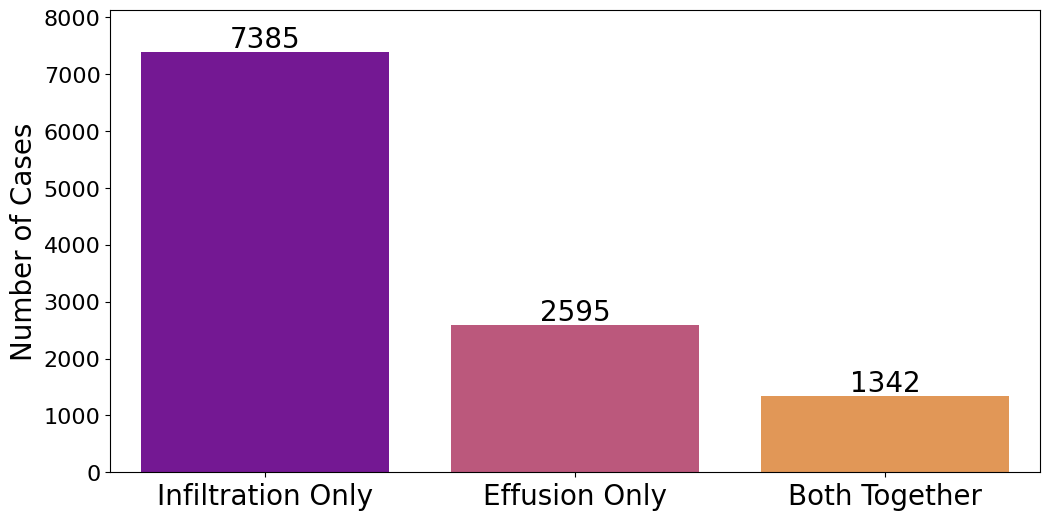

In [19]:
print("\nLabel Co-occurrence Analysis")

# Column 0 is Infiltration, Column 1 is Effusion
infiltration_col = labels_matrix[:, 0]
effusion_col = labels_matrix[:, 1]

infiltration_only = np.sum((infiltration_col == 1) & (effusion_col == 0))
effusion_only = np.sum((infiltration_col == 0) & (effusion_col == 1))
both_together = np.sum((infiltration_col == 1) & (effusion_col == 1))

categories = [
    f'Infiltration Only',
    f'Effusion Only',
    f'Both Together'
]
counts = [infiltration_only, effusion_only, both_together]

print(f"Number of 'Infiltration Only' cases: {infiltration_only}")
print(f"Number of 'Effusion Only' cases: {effusion_only}")
print(f"Number of 'Both Together' cases: {both_together}")

# --- Visualization ---
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=categories, y=counts, palette="plasma")
plt.ylabel('Number of Cases', fontsize=20)
plt.xlabel('')
max_height = max(counts)
plt.ylim(top=max_height * 1.1)
plt.xticks(fontsize=20)
plt.yticks(fontsize=16)
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points',
                     fontsize=20)
plt.savefig('co-occurrence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Image Characteristics Analysis


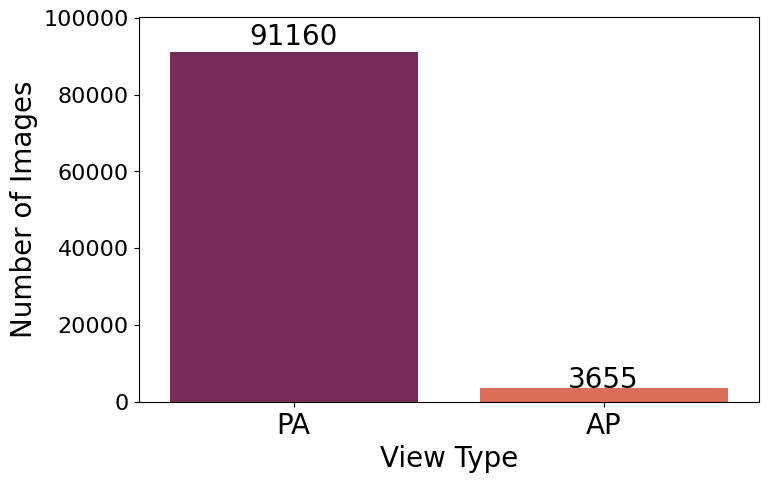

In [22]:
print("\nImage Characteristics Analysis")
df_filtered = dataset_for_analysis.csv

# Visualization: PA vs AP View
view_counts = df_filtered['Projection'].value_counts()
plt.figure(figsize=(8, 5))
max_height = max(view_counts)
plt.xticks(fontsize=20)
plt.yticks(fontsize=16)
plt.ylim(top=max_height * 1.1)
sns.barplot(x=view_counts.index, y=view_counts.values, palette="rocket")
plt.ylabel('Number of Images', fontsize=20); plt.xlabel('View Type', fontsize=20)
for index, value in enumerate(view_counts.values):
    plt.text(index, value + (value * 0.02), str(value), ha='center', fontsize=20)
    plt.savefig('view_distribution.png', dpi=300, bbox_inches='tight')
plt.show()